# Spatial Patterns – Cluster 15 (and Cluster 14 intake context)

This notebook adds a **geographic lens** to the interconnection queue analysis.

Because the public exports used in this repo do **not** include latitude/longitude for each project or POI, the maps in this notebook use a **county-based spatial join** (Cluster 15 provides county fields).

What this notebook does:
- ✅ Maps **Cluster 15** project counts / MW / withdrawal rate by **California county**
- ✅ Produces POI and county summary tables for future enrichment
- ✅ Sets up a GIS-friendly folder layout so you can later layer transmission lines / substations

What this notebook does not do (yet):
- ❌ POI/substation exact-coordinate mapping (requires an external POI/substation geospatial dataset or geocoding)

Inputs:
- `data/processed/cluster15_clean.csv`
- (optional) `data/processed/cluster14_intake_clean.csv` (for non-mapped context tables)

Outputs:
- Figures → `outputs/figures/`
- Tables → `outputs/tables/`


## 1) Imports

We use **GeoPandas** for vector GIS operations.

If GeoPandas isn't installed yet, install it into your venv and restart the kernel:
```bash
pip install geopandas shapely pyproj fiona
```


In [5]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import geopandas as gpd
except ImportError as e:
    raise ImportError(
        "geopandas is not installed. Install it in your venv with: "
        "pip install geopandas shapely pyproj fiona"
    ) from e

print('Python:', sys.version)
print('Executable:', sys.executable)
print('GeoPandas:', gpd.__version__)


Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Executable: C:\Users\danci\Interconnection-Queue-Intelligence\.venv\Scripts\python.exe
GeoPandas: 1.1.2


## 2) Paths + outputs + GIS folders

We store shapefiles/geojson under `data/raw/gis/` so future layers (transmission lines, substations) can live in one place.

In [6]:
ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

RAW = ROOT / "data" / "raw"
GIS = RAW / "gis"
PROCESSED = ROOT / "data" / "processed"

OUTPUTS = ROOT / "outputs"
FIGURES = OUTPUTS / "figures"
TABLES = OUTPUTS / "tables"

GIS.mkdir(parents=True, exist_ok=True)
FIGURES.mkdir(parents=True, exist_ok=True)
TABLES.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("GIS dir:", GIS)


ROOT: C:\Users\danci\Interconnection-Queue-Intelligence
GIS dir: C:\Users\danci\Interconnection-Queue-Intelligence\data\raw\gis


## 3) Load cleaned Cluster 15 table

In [7]:
cluster15 = pd.read_csv(PROCESSED / "cluster15_clean.csv")

print("Rows:", len(cluster15))
print("Columns:", list(cluster15.columns))
cluster15.head(3)


Rows: 170
Columns: ['queue_number', 'project_number', 'project_name', 'fuel_1', 'fuel_2', 'fuel_3', 'mw_1', 'mw_2', 'mw_3', 'net_mw', 'county', 'state', 'study_area', 'pto', 'poi', 'voltage_kv', 'requested_cod', 'queue_date', 'application_date', 'withdrawal_date', 'service_type', 'status', 'days_queue_to_withdrawal', 'days_app_to_withdrawal', 'technology', 'is_withdrawn', 'is_active']


,queue_number,project_number,project_name,fuel_1,fuel_2,fuel_3,mw_1,mw_2,mw_3,net_mw,...,queue_date,application_date,withdrawal_date,service_type,status,days_queue_to_withdrawal,days_app_to_withdrawal,technology,is_withdrawn,is_active
0,2207,54516,Alisa Solar Energy Complex 2,Photovoltaic/Solar,Storage/Battery,NaN,500.000000,500.000000,NaN,1000.000000,...,NaN,2024-11-18,NaN,Energy Only Requested,active,NaN,NaN,other,0,1
1,2328,54934,Amanece,Photovoltaic/Solar,Storage/Battery,NaN,418.992798,416.545013,NaN,835.537811,...,NaN,2024-11-21,NaN,Full Capacity Deliverability Status Requested,active,NaN,NaN,other,0,1
2,2322,55045,Ambar Energy Storage,Storage/Battery,NaN,NaN,504.900000,NaN,NaN,504.900000,...,NaN,2024-11-21,NaN,Full Capacity Deliverability Status Requested,active,NaN,NaN,other,0,1


### Sanity check: required fields for county maps

In [8]:
required = ["status", "net_mw"]
missing = [c for c in required if c not in cluster15.columns]
if missing:
    raise KeyError(f"Cluster 15 cleaned table is missing required columns: {missing}")

# Try common county column names (depends on source export)
county_col = None
for c in ["county", "County", "COUNTY"]:
    if c in cluster15.columns:
        county_col = c
        break

print("Detected county column:", county_col)
if county_col is None:
    raise KeyError(
        "No county field found in cluster15_clean.csv. "
        "To make county maps, the Cluster 15 export must include County."
    )


Detected county column: county


## 4) Download California counties boundary GeoJSON (once)

We download a public California counties GeoJSON and cache it locally.

If you are offline, this step may fail—run again when you have internet.
The cached file path will be: `data/raw/gis/california-counties.geojson`.

In [9]:
import urllib.request

CA_COUNTIES_URL = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/california-counties.geojson"
CA_COUNTIES_PATH = GIS / "california-counties.geojson"

if not CA_COUNTIES_PATH.exists():
    print("Downloading:", CA_COUNTIES_URL)
    urllib.request.urlretrieve(CA_COUNTIES_URL, CA_COUNTIES_PATH)
    print("Saved:", CA_COUNTIES_PATH)
else:
    print("Using cached:", CA_COUNTIES_PATH)

counties = gpd.read_file(CA_COUNTIES_PATH)
counties.head(3)


Downloading: https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/california-counties.geojson
Saved: C:\Users\danci\Interconnection-Queue-Intelligence\data\raw\gis\california-counties.geojson


,name,cartodb_id,created_at,updated_at,geometry
0,Alameda,1,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"MULTIPOLYGON (((-122.31293 37.89733, -122.2884..."
1,Alpine,2,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-120.07239 38.70277, -119.96495 38.7..."
2,Amador,3,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-121.02726 38.48925, -121.02741 38.5..."


### Standardize county names and fix CRS

We normalize names so we can join reliably.
GeoJSONs commonly come in WGS84 (EPSG:4326).

In [10]:
# Ensure CRS is set
if counties.crs is None:
    counties = counties.set_crs(epsg=4326)

def norm_county_name(x: str) -> str:
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    s = s.replace(" county", "")
    return s

# The click_that_hood geojson uses "name"
if "name" not in counties.columns:
    raise KeyError(f"Expected a 'name' column in counties geojson, found: {list(counties.columns)}")

counties["county_norm"] = counties["name"].apply(norm_county_name)

# Normalize cluster15 county
cluster15["county_norm"] = cluster15[county_col].apply(norm_county_name)

# Optional: drop rows without county
cluster15 = cluster15[cluster15["county_norm"].notna()].copy()

counties[["name", "county_norm"]].head()


,name,county_norm
0,Alameda,alameda
1,Alpine,alpine
2,Amador,amador
3,Butte,butte
4,Calaveras,calaveras


## 5) County-level summaries (Cluster 15)

We compute:
- project count by county
- MW by county
- withdrawal rate by county (count-based)
- MW-weighted withdrawal share by county


In [11]:
# Basic flags
cluster15["is_withdrawn"] = (cluster15["status"].str.lower() == "withdrawn").astype(int)
cluster15["is_active"] = (cluster15["status"].str.lower() == "active").astype(int)

county_counts = (cluster15
                 .groupby("county_norm")
                 .agg(
                     projects=("status", "size"),
                     withdrawn_projects=("is_withdrawn", "sum"),
                     active_projects=("is_active", "sum"),
                     total_mw=("net_mw", "sum"),
                     withdrawn_mw=("net_mw", lambda s: s[cluster15.loc[s.index, "status"].str.lower()=="withdrawn"].sum()),
                 )
                 .reset_index())

county_counts["withdrawal_rate_count"] = county_counts["withdrawn_projects"] / county_counts["projects"]
county_counts["withdrawal_share_mw"] = county_counts["withdrawn_mw"] / county_counts["total_mw"]

county_counts = county_counts.sort_values("projects", ascending=False)
county_counts.head(10)


,county_norm,projects,withdrawn_projects,active_projects,total_mw,withdrawn_mw,withdrawal_rate_count,withdrawal_share_mw
25,san bernardino,25,5,20,11085.333480,2301.131280,0.200000,0.207583
5,fresno,19,4,15,14149.267973,1396.072973,0.210526,0.098668
8,kern,15,3,12,8191.667346,3107.950000,0.200000,0.379404
17,merced,12,6,6,4293.489000,1974.035000,0.500000,0.459774
20,nye,12,5,7,8690.097100,6392.322600,0.416667,0.735587
14,los angeles,10,4,6,5160.093373,2091.738100,0.400000,0.405368
22,riverside,7,1,6,2264.610500,407.326400,0.142857,0.179866
27,san joaquin,7,2,5,1741.605391,610.189490,0.285714,0.350360
10,kings,6,1,5,2733.792951,309.700000,0.166667,0.113286
30,stanislaus,5,3,2,1442.261811,339.144000,0.600000,0.235147


### Save: county summary table

In [12]:
out = TABLES / "cluster15_county_summary.csv"
county_counts.to_csv(out, index=False)
print("Saved:", out)


Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\tables\cluster15_county_summary.csv


## 6) Join summaries to county polygons

In [13]:
county_gdf = counties.merge(county_counts, on="county_norm", how="left")

# Fill missing counties with zeros for plotting
for col in ["projects", "withdrawn_projects", "active_projects", "total_mw", "withdrawn_mw",
            "withdrawal_rate_count", "withdrawal_share_mw"]:
    if col in county_gdf.columns:
        county_gdf[col] = county_gdf[col].fillna(0)

county_gdf[["name", "projects", "withdrawal_rate_count", "total_mw"]].sort_values("projects", ascending=False).head(10)


,name,projects,withdrawal_rate_count,total_mw
55,San Bernardino,25.0,0.200000,11085.333480
10,Fresno,19.0,0.210526,14149.267973
36,Kern,15.0,0.200000,8191.667346
26,Merced,12.0,0.500000,4293.489000
21,Los Angeles,10.0,0.400000,5160.093373
52,Riverside,7.0,0.142857,2264.610500
56,San Joaquin,7.0,0.285714,1741.605391
44,Kings,6.0,0.166667,2733.792951
0,Alameda,5.0,0.600000,1827.460000
39,Santa Clara,5.0,0.800000,984.040000


## 7) Map 1: Withdrawal rate by county (project-count)

This is a choropleth where darker counties have a higher share of withdrawn projects.
Interpretation caution:
- Small denominators can create noisy rates.
- Use alongside the project-count map.

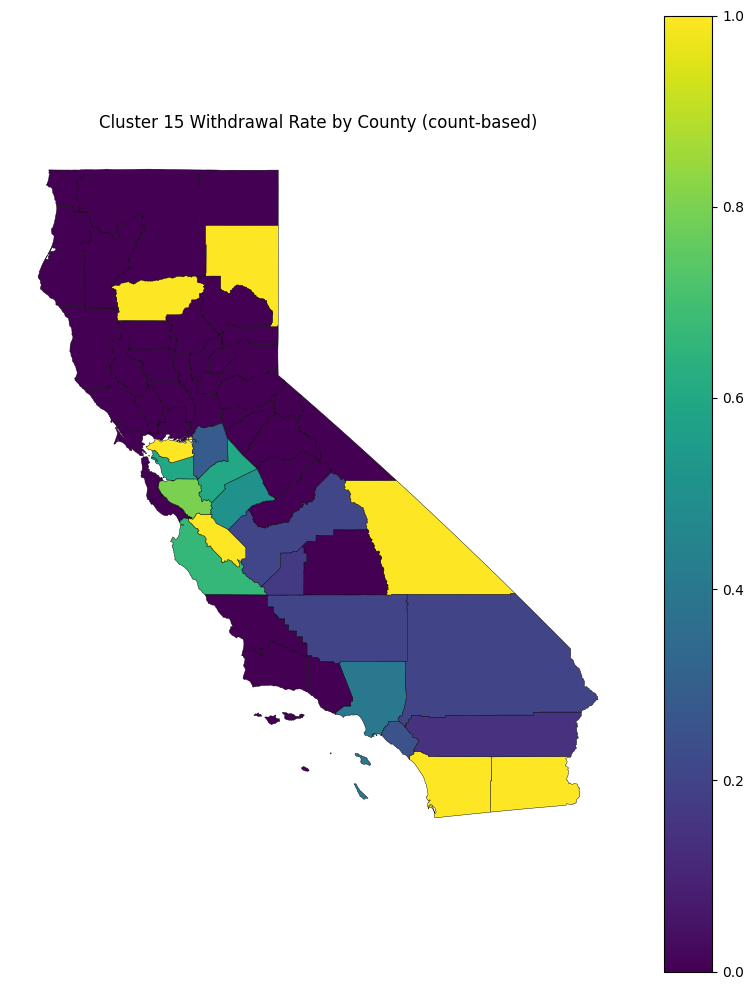

Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\figures\cluster15_withdrawal_rate_by_county.png


In [14]:
ax = county_gdf.plot(
    column="withdrawal_rate_count",
    legend=True,
    figsize=(8, 10),
    edgecolor="black",
    linewidth=0.3
)
ax.set_title("Cluster 15 Withdrawal Rate by County (count-based)")
ax.set_axis_off()

out = FIGURES / "cluster15_withdrawal_rate_by_county.png"
plt.tight_layout()
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)


## 8) Map 2: Total MW by county

This choropleth shows where proposed capacity is concentrated.
It complements the withdrawal-rate map.

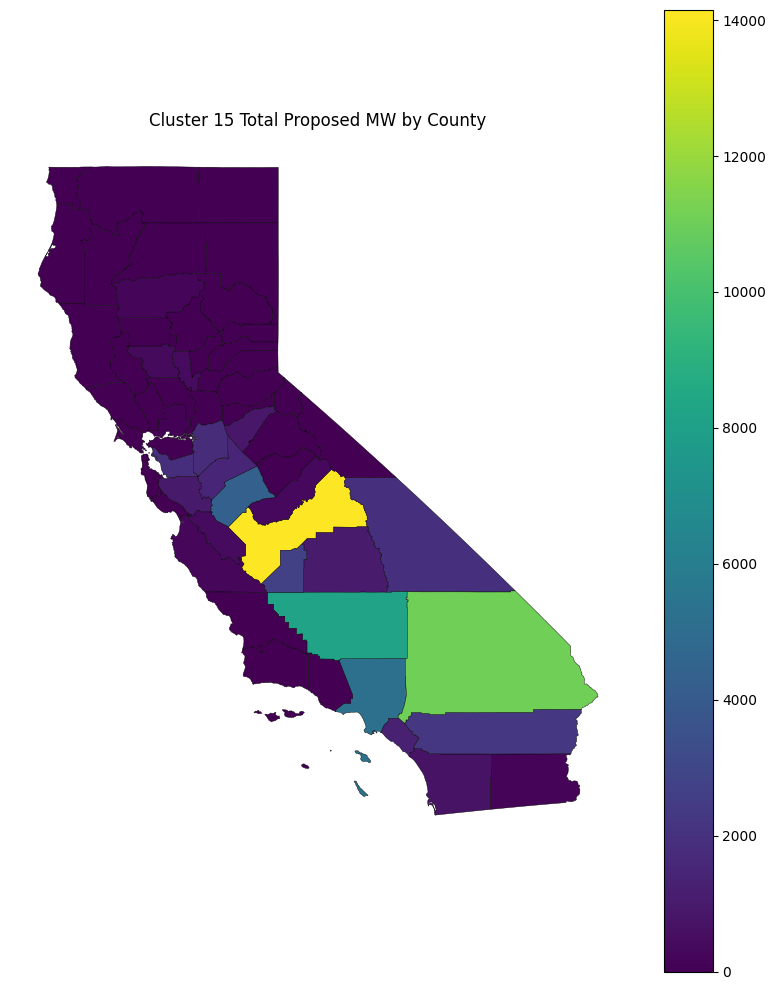

Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\figures\cluster15_total_mw_by_county.png


In [15]:
ax = county_gdf.plot(
    column="total_mw",
    legend=True,
    figsize=(8, 10),
    edgecolor="black",
    linewidth=0.3
)
ax.set_title("Cluster 15 Total Proposed MW by County")
ax.set_axis_off()

out = FIGURES / "cluster15_total_mw_by_county.png"
plt.tight_layout()
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)


## 9) Map 3: Bubble overlay (centroids)

We plot one bubble per county at the polygon centroid.
- Bubble size = total MW
- Bubble color = withdrawal rate

This provides a compact view of **scale vs attrition**.

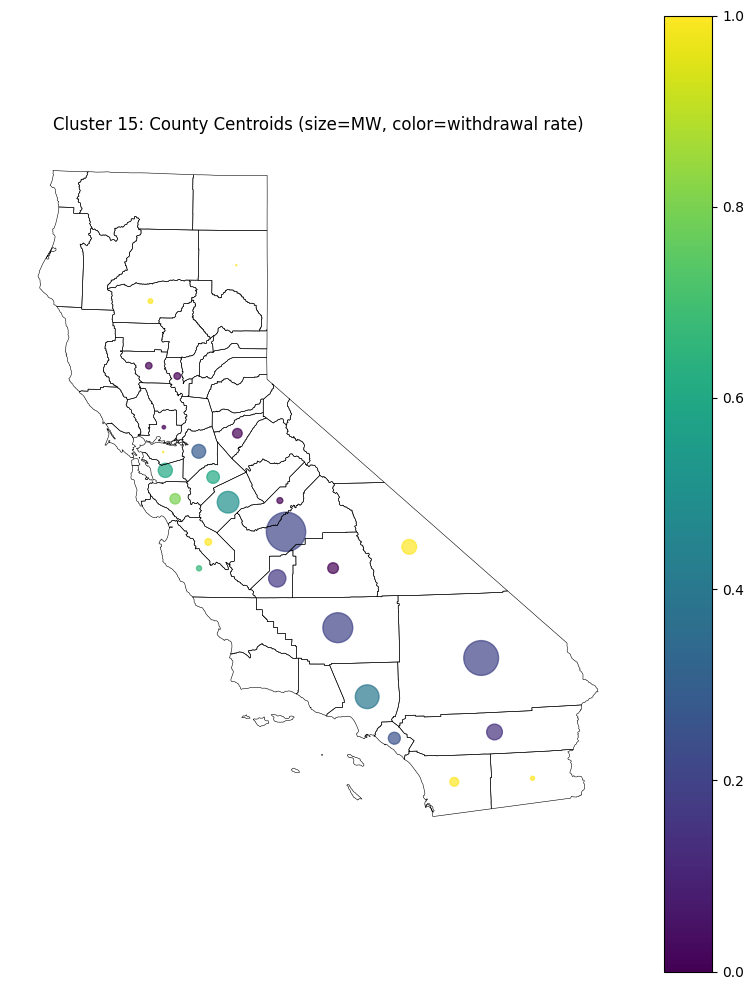

Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\figures\cluster15_bubble_mw_vs_withdrawal_rate.png


In [16]:
# Work in a projected CRS for nicer centroids (California Albers)
county_proj = county_gdf.to_crs(epsg=3310)
county_proj["centroid"] = county_proj.geometry.centroid
centroids = gpd.GeoDataFrame(county_proj.drop(columns="geometry"), geometry="centroid", crs=county_proj.crs)

fig, ax = plt.subplots(figsize=(8, 10))
county_proj.boundary.plot(ax=ax, linewidth=0.4, color="black")

# Scale bubble sizes
mw = centroids["total_mw"].fillna(0)
sizes = (mw / mw.max() * 800) if mw.max() > 0 else mw

centroids.plot(
    ax=ax,
    column="withdrawal_rate_count",
    legend=True,
    markersize=sizes,
    alpha=0.7,
)

ax.set_title("Cluster 15: County Centroids (size=MW, color=withdrawal rate)")
ax.set_axis_off()

out = FIGURES / "cluster15_bubble_mw_vs_withdrawal_rate.png"
plt.tight_layout()
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)


## 10) Optional: Cluster 14 intake context (non-mapped)

Cluster 14 intake file in this repo does not reliably include county names.
We still summarize **top POIs / PTOs** so you can later map Cluster 14 once you obtain POI/substation coordinates.

In [17]:
c14_path = PROCESSED / "cluster14_intake_clean.csv"
if c14_path.exists():
    c14 = pd.read_csv(c14_path)

    # POI concentration
    if "poi" in c14.columns:
        c14_top_poi = c14["poi"].value_counts().head(30).rename("projects").to_frame()
        c14_top_poi.to_csv(TABLES / "cluster14_top_pois_for_future_mapping.csv")
        print("Saved:", TABLES / "cluster14_top_pois_for_future_mapping.csv")

    # Voltage distribution
    if "voltage_kv" in c14.columns:
        c14_voltage = c14["voltage_kv"].value_counts().sort_index().rename("projects").to_frame()
        c14_voltage.to_csv(TABLES / "cluster14_voltage_distribution_for_context.csv")
        print("Saved:", TABLES / "cluster14_voltage_distribution_for_context.csv")
else:
    print("Cluster 14 processed file not found; run Notebook 05 if you want Cluster 14 context tables.")


Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\tables\cluster14_top_pois_for_future_mapping.csv
Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\tables\cluster14_voltage_distribution_for_context.csv


## 11) Next steps for POI/substation-level maps (future)

To map projects at the POI/substation level (not county), you need coordinates for POIs.

Two good upgrade paths:
1. **Substation / POI geospatial dataset** (public GIS layer) → join by POI name.
2. **CAISO POI Heatmap data** (if a machine-readable export is available) → use its coordinates.

Once you have coordinates, this notebook can be extended by:
- constructing a POI table (POI → lat/lon)
- joining Cluster 14 & 15 projects to POI geometry
- layering transmission lines (shapefiles/geojson) in `data/raw/gis/`
